# Credit Card Fraud Detection

Predict fraudulent credit card transactions with the help of machine learning models.

# 1. Preparation
### 1.1. Import the required libraries.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier

from pycaret.classification import ClassificationExperiment

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

import warnings
warnings.filterwarnings("ignore")

### 1.2. Define reusable methods 

In [2]:
# Define a method to plot the ROC curve
def plot_roc_curve(y, y_pred, title):
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred[:,1], drop_intermediate = False )
    auc_score = metrics.roc_auc_score(y, y_pred[:,1] )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.3f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title(title, fontsize=12)
    plt.legend(loc="lower right")
    plt.show()

# 2. Exploratory data analysis
### 2.1. Import the dataset

In [3]:
# Configure Pandas to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df = pd.read_csv('creditcard.csv')
df.head(20)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [5]:
# Observe the different feature type present in the data
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### 2.2. Compute the descriptive statistics 

In [6]:
# Observe the different feature type present in the data
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### 2.3. Find the correlations between independent variables

In [7]:
# Find the correlations between independent variables
df.corr().round(3).unstack().sort_values().drop_duplicates()

V2      Amount   -0.531
V3      Time     -0.420
V5      Amount   -0.386
V17     Class    -0.326
Class   V14      -0.303
V12     Class    -0.261
Time    V11      -0.248
        V25      -0.233
V1      Amount   -0.228
V10     Class    -0.217
Amount  V3       -0.211
Class   V16      -0.197
V3      Class    -0.193
Class   V7       -0.187
V15     Time     -0.183
V23     Amount   -0.113
Class   V18      -0.111
V4      Time     -0.105
Amount  V8       -0.103
        V10      -0.102
V1      Class    -0.101
Time    V14      -0.099
Class   V9       -0.098
V5      Class    -0.095
V17     Time     -0.073
V13     Time     -0.066
V22     Amount   -0.065
Time    V6       -0.063
Amount  V19      -0.056
V20     Time     -0.051
V25     Amount   -0.048
Class   V6       -0.044
Time    V26      -0.041
        V8       -0.037
        V24      -0.016
Class   Time     -0.012
V2      Time     -0.011
V12     Amount   -0.010
Time    V9       -0.009
Class   V24      -0.007
V13     Class    -0.005
V16     Amount  

### 2.4. Observe the class distribution

In [8]:
# Show the class distribution
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100
print('Normal share: ', normal_share)
print('Fraud share: ', fraud_share)

Normal share:  99.82725143693798
Fraud share:  0.1727485630620034


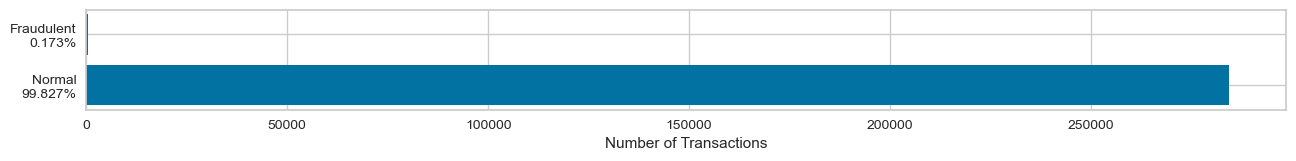

In [9]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
fig = plt.figure(figsize = (12, 1))
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Number of Transactions')
class_value_counts = df['Class'].value_counts()
normal_text = 'Normal\n' + str(round(normal_share, 3)) + '%'
fraud_test = 'Fraudulent\n' + str(round(fraud_share, 3)) + '%'

plt.barh([normal_text, fraud_test], class_value_counts)

#for i, v in enumerate(class_value_counts):
#    ax.text(v + 1000, i + 0, str(v), color='black', fontweight='bold')

plt.show()

In [10]:
# Devide the dataset into separate datasets for users who have churned and users who have not churned
normal_only = df[df['Class'] == 0]
fraud_only = df[df['Class'] == 1]

### 2.5. Visualize the predictor variables

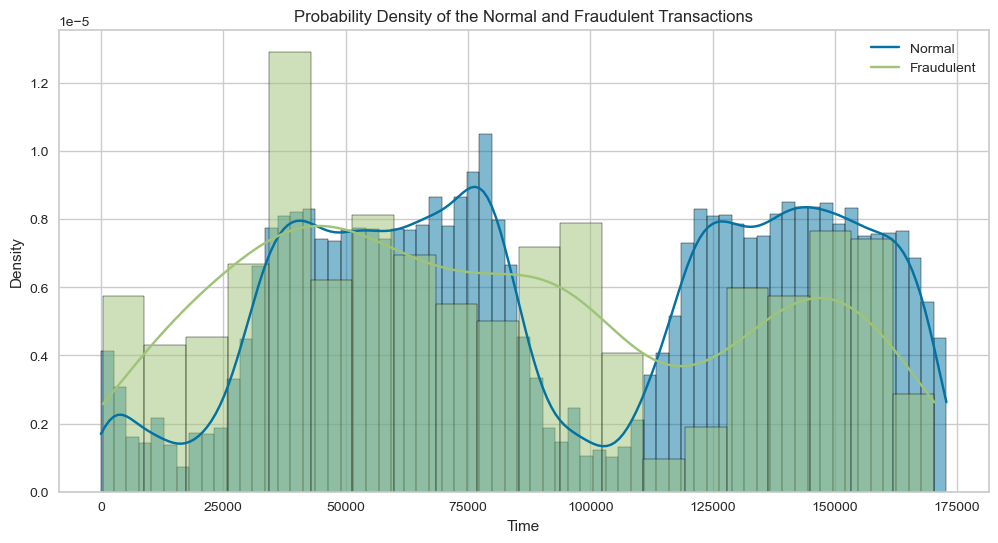

In [11]:
# Plot the probability density of normal and fraudulent transactions versus time
plt.figure(figsize = (12,6))
sns.histplot(normal_only['Time'], kde=True, stat='density')
sns.histplot(fraud_only['Time'], kde=True, stat='density', bins=20)
plt.legend(['Normal', 'Fraudulent'])
plt.xlabel('Time')
plt.title('Probability Density of the Normal and Fraudulent Transactions')
plt.show()

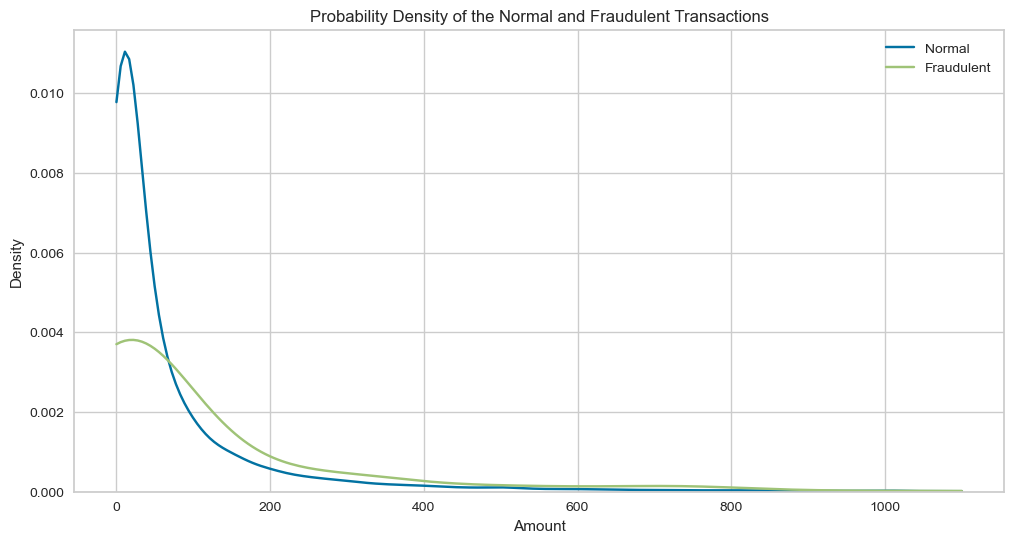

In [12]:
# Plot the probability density of normal and fraudulent transactions versus amount
plt.figure(figsize = (12,6))
sns.kdeplot(normal_only['Amount'], clip=[0, 1100])
sns.kdeplot(fraud_only['Amount'], clip=[0, 1100])
plt.legend(['Normal', 'Fraudulent'])
plt.xlabel('Amount')
plt.title('Probability Density of the Normal and Fraudulent Transactions')
plt.show()

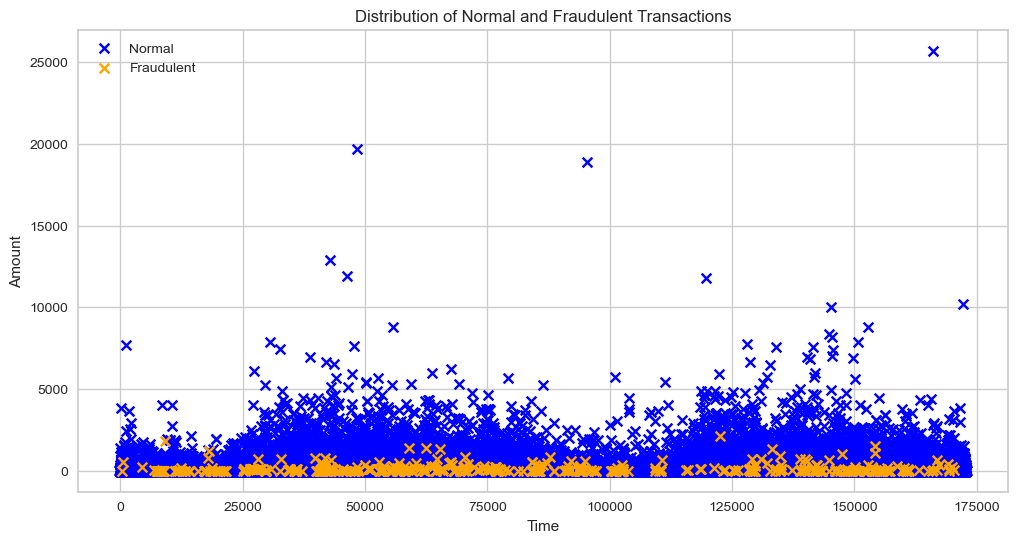

In [13]:
# Create a scatter plot to observe the distribution of classes with time and amount
plt.figure(figsize = (12,6))
plt.scatter(x=normal_only['Time'], y=normal_only['Amount'], c='blue', marker='x', label='Normal')
plt.scatter(x=fraud_only['Time'], y=fraud_only['Amount'], c='orange', marker='x', label='Fraudulent')
plt.legend(loc='upper left')
plt.ylabel('Amount')
plt.xlabel('Time')
plt.title('Distribution of Normal and Fraudulent Transactions')
plt.show()

### 2.6. Split the data into training and test datasets

In [14]:
# Drop unnecessary columns
df.drop('Time', axis='columns', inplace=True)

In [15]:
# Move the dependent variable
y = df.pop('Class')
X = df

In [16]:
# Split the data into train and test using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=42)

In [17]:
# Validate the train and test class distribution after stratified sampling
train_classes = y_train.value_counts()
train_normal_share = train_classes[0] / y_train.count() * 100
train_fraud_share = train_classes[1] / y_train.count() * 100

test_classes = y_test.value_counts()
test_normal_share = test_classes[0] / y_test.count() * 100
test_fraud_share = test_classes[1] / y_test.count() * 100

print('Train normal share: ', train_normal_share)
print('Test normal share:  ', test_normal_share)
print('Train fraudulent share: ', train_fraud_share)
print('Test fraudulent share:  ', test_fraud_share)

Train normal share:  99.82725123475575
Test normal share:   99.82725204348193
Train fraudulent share:  0.17274876524425925
Test fraudulent share:   0.17274795651807534


In [18]:
print('Fraudulent data points in training dataset: ', np.sum(y_train))
print('Fraudulent data points in test dataset: ', np.sum(y_test))

Fraudulent data points in training dataset:  369
Fraudulent data points in test dataset:  123


### 2.7. Plot the prediction variable distributions

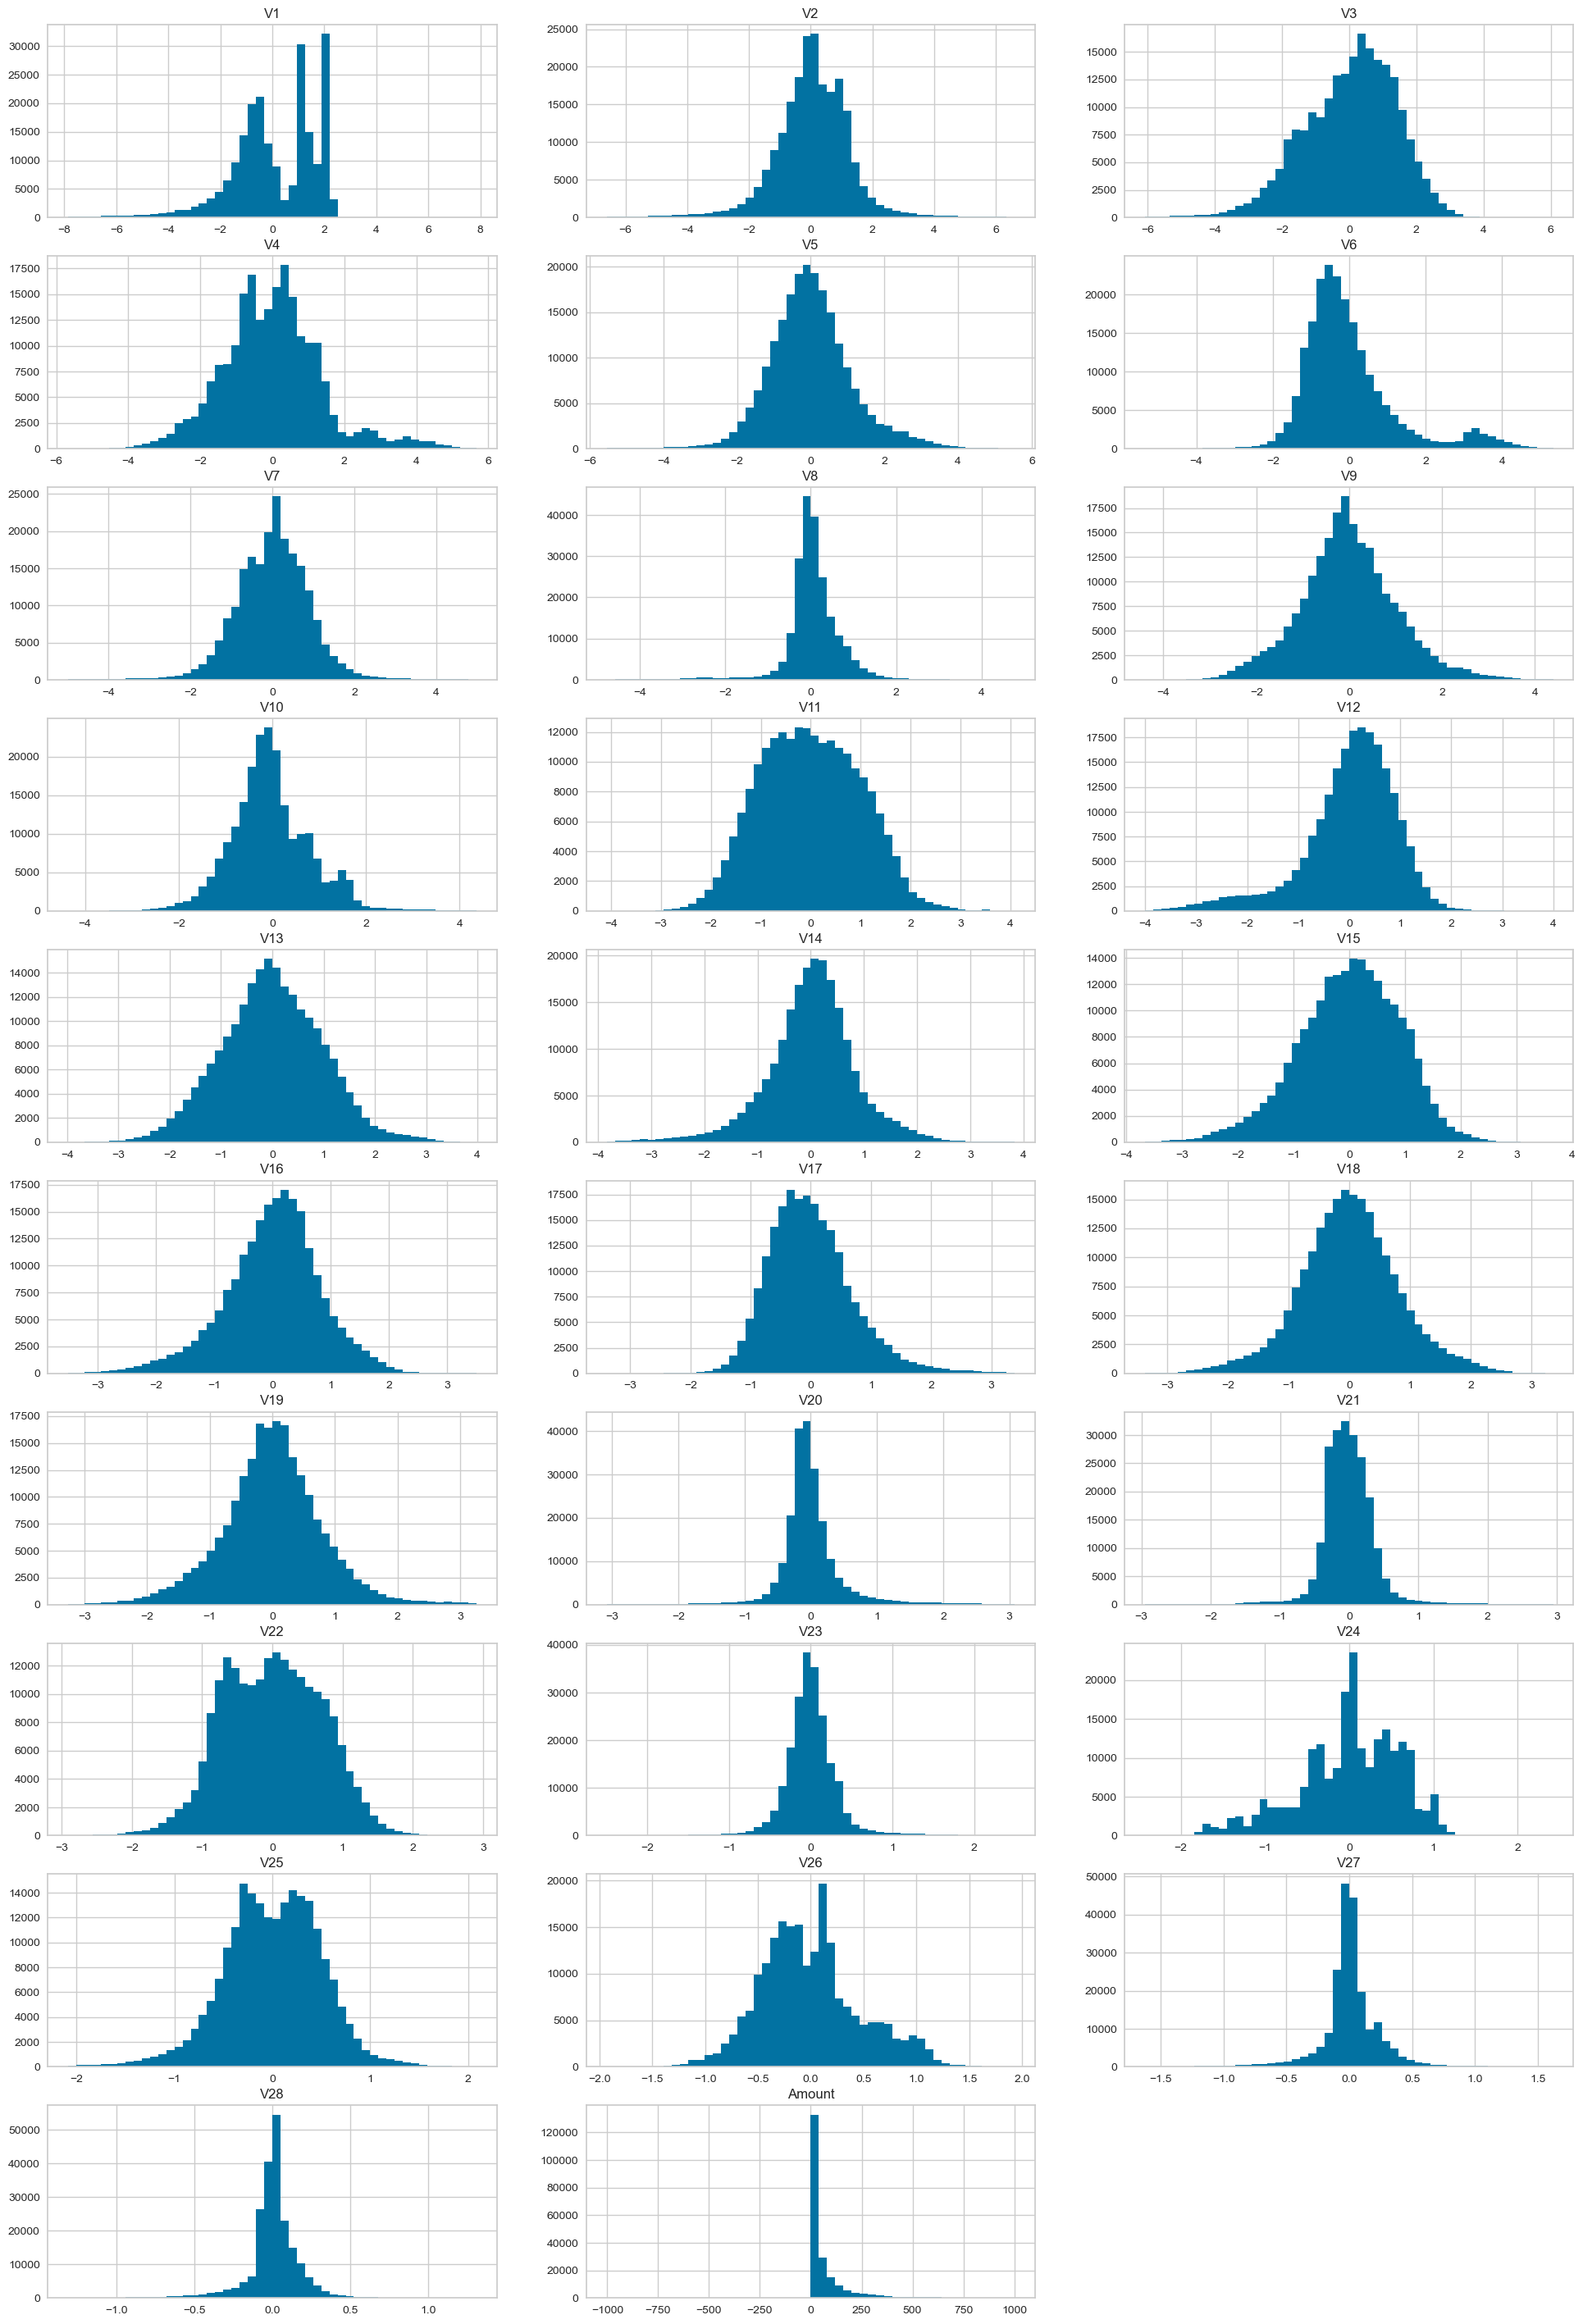

In [19]:
# Plot the histogram of a variable from the dataset to see the skewness
plt.figure(figsize=(24,36))

stats_df = X_train.describe()

fig_number = 0
for column in X_train.columns:
    fig_number = fig_number + 1
    plt.subplot(10, 3, fig_number)
    four_stdv = 4 * stats_df[column]['std']
    plt.hist(X_train[column], bins= 50, range=[-four_stdv, four_stdv])
    plt.title(column)

plt.show()

### 2.8. Deskew and standardize the data

In [20]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
power_transformer = preprocessing.PowerTransformer(standardize=True, copy=False)
power_transformer.fit_transform(X_train)
power_transformer.transform(X_test)

array([[-2.24454146,  4.05138446, -0.06886985, ...,  3.65702034,
        -1.12390699, -0.49168395],
       [ 1.28502474,  0.26272535, -0.60032919, ..., -0.11804868,
        -0.14162217,  0.14612052],
       [-0.83775003,  0.84029533,  0.85847465, ..., -0.27328573,
         0.01293674,  1.14874772],
       ...,
       [ 0.69262158, -0.85730171,  1.16895496, ...,  0.19365194,
         0.06166031, -1.07658801],
       [-0.5723107 , -0.26950584,  1.06706504, ..., -0.21866511,
         0.24767058,  0.16671359],
       [-0.26152653,  0.58105208, -0.39152116, ..., -0.02352932,
        -0.3229619 , -0.71551985]])

### 2.9. Plot the prediction variable distributions after deskewing

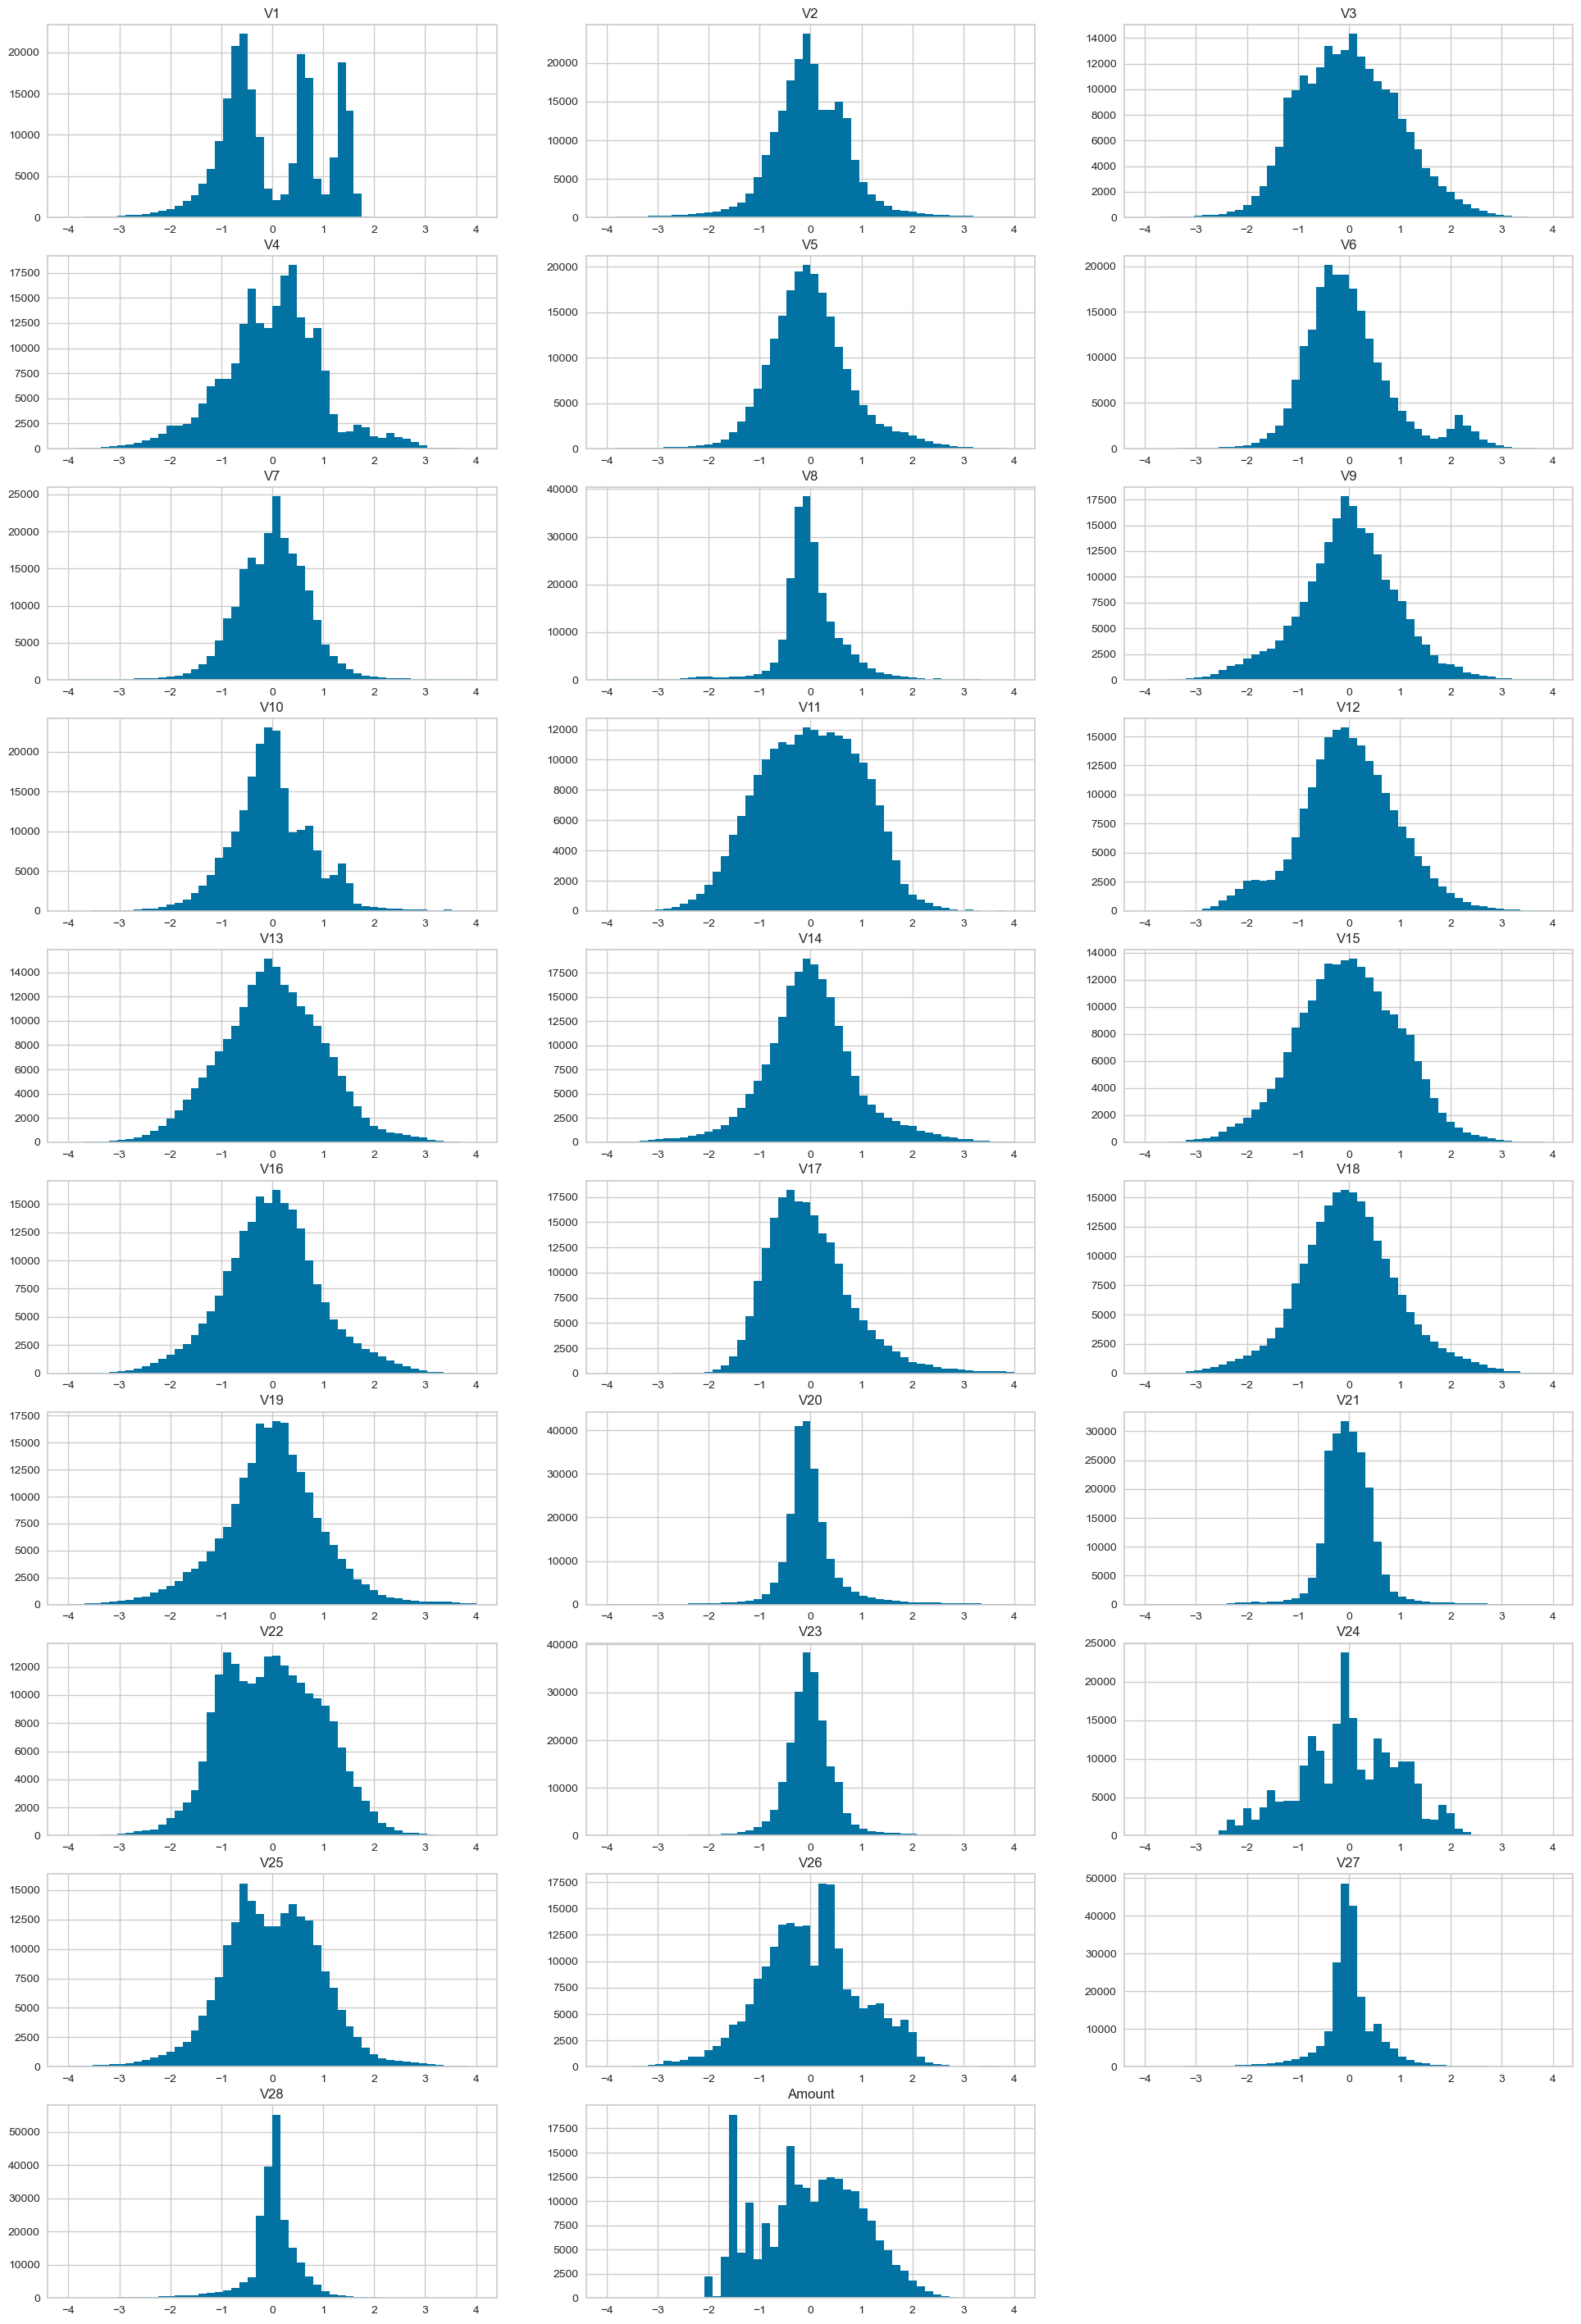

In [21]:
# plot the histogram of the variables from the dataset again to see the result
plt.figure(figsize=(24,36))

stats_df = X_train.describe()

fig_number = 0
for column in X_train.columns:
    fig_number = fig_number + 1
    plt.subplot(10, 3, fig_number)
    four_stdv = 4 * stats_df[column]['std']
    plt.hist(X_train[column], bins= 50, range=[-four_stdv, four_stdv])
    plt.title(column)

plt.show()

# 3. Model building with imbalanced classes
Build different models on the imbalanced dataset and see the result.

## 3.1. Logistic Regression model on imbalanced data

### 3.1.1. Logistic regression model building

In [22]:
# Define and fit a logistic regression model using cross validation
logistic_regression_cv = LogisticRegressionCV(cv=5, scoring='roc_auc', random_state=42)
logistic_regression_cv.fit(X_train, y_train)

LogisticRegressionCV(cv=5, random_state=42, scoring='roc_auc')

### 3.1.2. Logistic regression model evaluation on training dataset

In [23]:
# Display the ROC AUC score on the training data
logistic_regression_cv.score(X_train, y_train)

0.9852117996315493

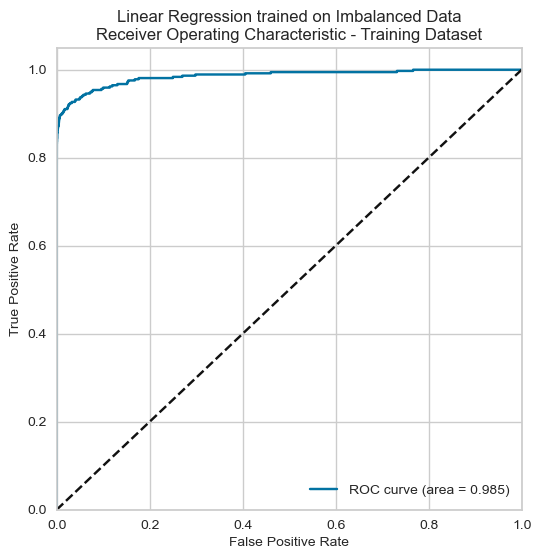

In [24]:
# Plot the ROC curve
lr_pred_prob_train = logistic_regression_cv.predict_proba(X_train)
plot_roc_curve(y_train, lr_pred_prob_train, 'Linear Regression without Balancing\nReceiver Operating Characteristic - Training Dataset')

### 3.1.3. Logistic regression model evaluation on test dataset

In [25]:
# Compute the ROC AUC score on the training dataset
lr_imbalanced_pred_prob_test = logistic_regression_cv.predict_proba(X_test)
roc_auc_score(y_test, lr_imbalanced_pred_prob_test[:, 1])

0.9706803960370672

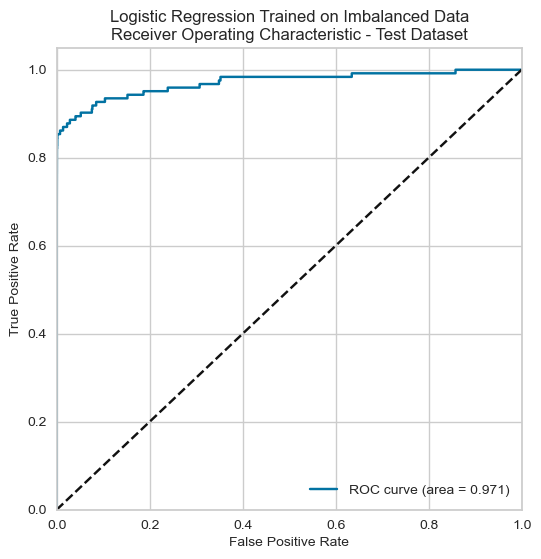

In [26]:
# Plot the ROC curve
plot_roc_curve(y_test, lr_imbalanced_pred_prob_test, 'Logistic Regression without Balancing\nReceiver Operating Characteristic - Test Dataset')

### 3.1.4. Logistic regression model hyperparameter tuning

In [28]:
# Tune the L2 regularization hyperparameter of the logistic regression model
grid = {'C': np.power(10.0, np.arange(-10, 10))}
logistic_regression = LogisticRegression(solver='newton-cg', penalty='l2', random_state=42, max_iter=10000, n_jobs=-1, verbose=3)
grid_search = GridSearchCV(logistic_regression, grid, scoring='roc_auc', cv=5)
grid_search.fit(X, y)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   10.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    6.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    6.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    7.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   

[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concu

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, n_jobs=8,
                                          random_state=42, solver='newton-cg',
                                          verbose=3),
             param_grid={'C': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09])},
             scoring='roc_auc')

In [29]:
# Display the hyperparameter tuning results
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.903964,1.586599,0.018790,0.001610,0.0,{'C': 1e-10},0.498896,0.555959,0.682851,0.588045,0.541709,0.573492,0.061731,3
1,6.129404,1.105635,0.018583,0.002237,0.0,{'C': 1e-09},0.500717,0.557368,0.684410,0.589616,0.543506,0.575124,0.061652,2
2,4.812523,0.238710,0.017983,0.001078,0.0,{'C': 1e-08},0.529445,0.576583,0.701058,0.612346,0.564621,0.596811,0.058468,1
3,0.904546,0.062600,0.018402,0.001607,0.0,{'C': 1e-07},0.644771,0.551942,0.467892,0.550441,0.606878,0.564385,0.059879,20
4,1.003716,0.032472,0.019600,0.002576,0.000001,{'C': 1e-06},0.644771,0.551945,0.467870,0.550450,0.606923,0.564392,0.059892,4
5,0.986201,0.051492,0.018189,0.000749,0.00001,{'C': 1e-05},0.644771,0.551946,0.467867,0.550451,0.606922,0.564392,0.059893,19
6,0.995357,0.039098,0.018782,0.001843,0.0001,{'C': 0.0001},0.644771,0.551946,0.467867,0.550451,0.606922,0.564392,0.059893,5
7,1.041630,0.059920,0.017792,0.001175,0.001,{'C': 0.001},0.644771,0.551946,0.467867,0.550451,0.606922,0.564392,0.059893,5
8,1.015672,0.044752,0.020397,0.003257,0.01,{'C': 0.01},0.644771,0.551946,0.467867,0.550451,0.606922,0.564392,0.059893,5
9,0.994184,0.056871,0.019783,0.002574,0.1,{'C': 0.1},0.644771,0.551946,0.467867,0.550451,0.606922,0.564392,0.059893,5


### 3.1.6. Finetuned logistic regression model evaluation on training dataset

In [32]:
# Compute the ROC AUC score on the training data
tuned_lr_pred_prob_train = grid_search.predict_proba(X_train)
roc_auc_score(y_train, tuned_lr_pred_prob_train[:, 1])

0.8955615852374924

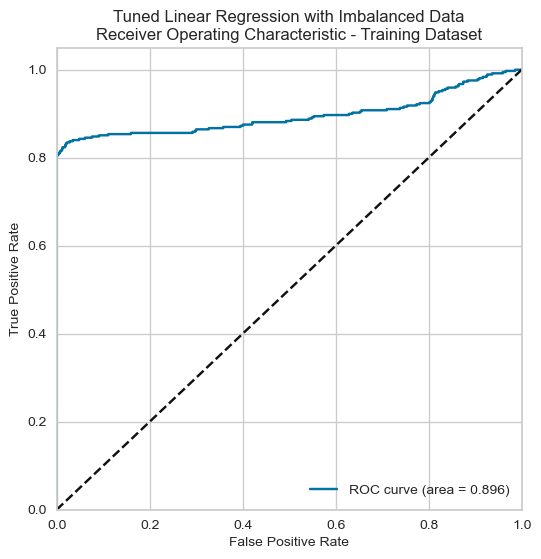

In [34]:
# Plot the ROC curve
plot_roc_curve(y_train, tuned_lr_pred_prob_train, 'Tuned Linear Regression model without Balancing\nReceiver Operating Characteristic - Training Dataset')

* The original linear regression model was better than the tuned model.

## 3.2. Compare models on imbalanced classes

### 3.2.1 Building and comparing models

In [22]:
# Configure pycaret to perform stratified sampling
imbalanced_experiment = ClassificationExperiment()
imbalanced_experiment.setup(data=X_train, target=y_train, fold_strategy='stratifiedkfold', fold=5, fold_shuffle=True, preprocess=False, pca=False, normalize=False, transformation=False, fix_imbalance=False, remove_outliers=False, session_id=42, use_gpu=True, html=False, verbose=True)

                   Description         Value
0                   Session id            42
1                       Target         Class
2                  Target type        Binary
3          Original data shape  (213605, 30)
4       Transformed data shape  (213605, 30)
5  Transformed train set shape  (149523, 30)
6   Transformed test set shape   (64082, 30)
7             Numeric features            29


In [23]:
# Build the models using cross validation and sort performance by ROC AUC
imbalanced_best = imbalanced_experiment.compare_models(exclude=['gbc', 'ada'], cross_validation=True, sort='AUC')

                                    Model  Accuracy     AUC  Recall   Prec.  \
lr                    Logistic Regression    0.9993  0.9811  0.6779  0.9177   
qda       Quadratic Discriminant Analysis    0.9841  0.9701  0.8603  0.0874   
nb                            Naive Bayes    0.9783  0.9616  0.8253  0.0625   
et                 Extra Trees Classifier    0.9995  0.9517  0.7750  0.9269   
rf               Random Forest Classifier    0.9995  0.9440  0.7790  0.9261   
knn                K Neighbors Classifier    0.9995  0.9204  0.7675  0.9103   
lda          Linear Discriminant Analysis    0.9994  0.8991  0.7710  0.8852   
dt               Decision Tree Classifier    0.9991  0.8738  0.7480  0.7530   
lightgbm  Light Gradient Boosting Machine    0.9942  0.6803  0.4735  0.1588   
dummy                    Dummy Classifier    0.9983  0.5000  0.0000  0.0000   
svm                   SVM - Linear Kernel    0.9992  0.0000  0.5692  0.9138   
ridge                    Ridge Classifier    0.9989 

* The K nearest neighbors, random forest, and logistic regression models appear to be good candidates with good recall rates.

## 3.3. Finetune K Nearest Neighbors model on imbalanced data

### 3.3.1. KNN model hyperparameter tuning

In [37]:
# Perform automated hyperparameter tuning on the KNN model
imbalanced_best_knn = imbalanced_experiment.tune_model(KNeighborsClassifier(), optimize='AUC', n_iter=10)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9994  0.9226  0.7692  0.8696  0.8163  0.8160  0.8176
1       0.9994  0.9226  0.7500  0.9070  0.8211  0.8208  0.8245
2       0.9996  0.9515  0.8462  0.8980  0.8713  0.8711  0.8715
3       0.9993  0.9406  0.7647  0.8298  0.7959  0.7956  0.7962
4       0.9995  0.9407  0.7843  0.8889  0.8333  0.8331  0.8347
Mean    0.9994  0.9356  0.7829  0.8786  0.8276  0.8273  0.8289
Std     0.0001  0.0113  0.0335  0.0274  0.0250  0.0250  0.0247


### 3.3.2. KNN model evaluation on training dataset

In [43]:
# Compute the ROC AUC score on the training dataset
knn_imbalanced_pred_prob_train = imbalanced_best_knn.predict_proba(X_train)
roc_auc_score(y_train, knn_imbalanced_pred_prob_train[:, 1])

0.9809185044335015

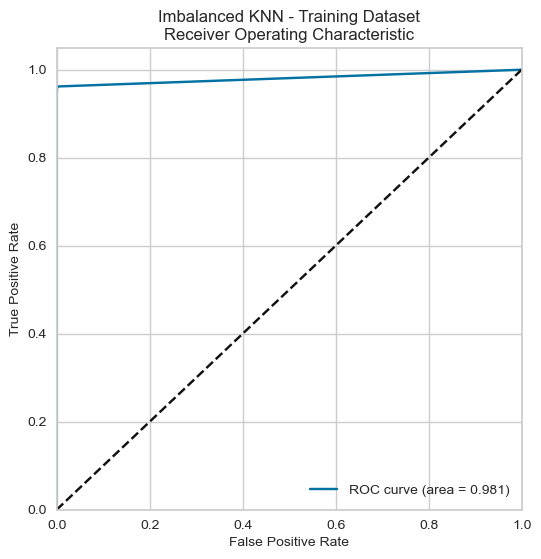

In [48]:
# Plot the ROC curve
plot_roc_curve(y_train, knn_imbalanced_pred_prob_train, 'KNN without Balancing\nReceiver Operating Characteristic - Training Dataset')

### 3.3.3. KNN model evaluation on test dataset

In [46]:
# Compute the ROC AUC score
imbalanced_best_knn_pred_prob_test = imbalanced_best_knn.predict_proba(X_test)
roc_auc_score(y_test, imbalanced_best_knn_pred_prob_test[:, 1])

0.9344508120301732

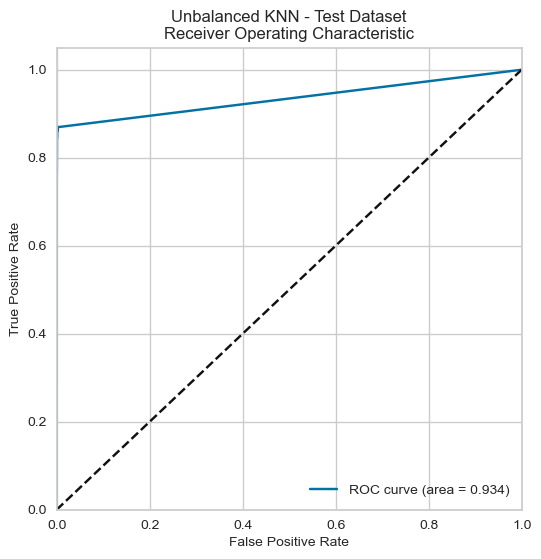

In [47]:
# Plot the ROC curve
plot_roc_curve(y_test, imbalanced_best_knn_pred_prob_test, 'KNN without Balancing\nReceiver Operating Characteristic - Test Dataset')

## 3.4. Finetune Random Forest model on imbalanced data

### 3.4.1. Random forest hyperparameter tuning

In [24]:
# Perform automated hyperparameter tuning on the random forest model
imbalanced_best_rf = imbalanced_experiment.tune_model(RandomForestClassifier(), optimize='AUC', n_iter=10)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9995  0.9972  0.7692  0.9302  0.8421  0.8419  0.8457
1       0.9996  0.9652  0.7500  1.0000  0.8571  0.8569  0.8658
2       0.9996  0.9787  0.8462  0.9362  0.8889  0.8887  0.8898
3       0.9994  0.9922  0.7255  0.9024  0.8043  0.8040  0.8089
4       0.9995  0.9895  0.7647  0.9070  0.8298  0.8295  0.8326
Mean    0.9995  0.9846  0.7711  0.9352  0.8445  0.8442  0.8486
Std     0.0001  0.0114  0.0405  0.0349  0.0282  0.0282  0.0277


### 3.4.2. Random forest model evaluation on training dataset

In [25]:
# Compute the ROC AUC score on the training dataset
rf_imbalanced_pred_prob_train = imbalanced_best_rf.predict_proba(X_train)
roc_auc_score(y_train, rf_imbalanced_pred_prob_train[:, 1])

0.9921400876954988

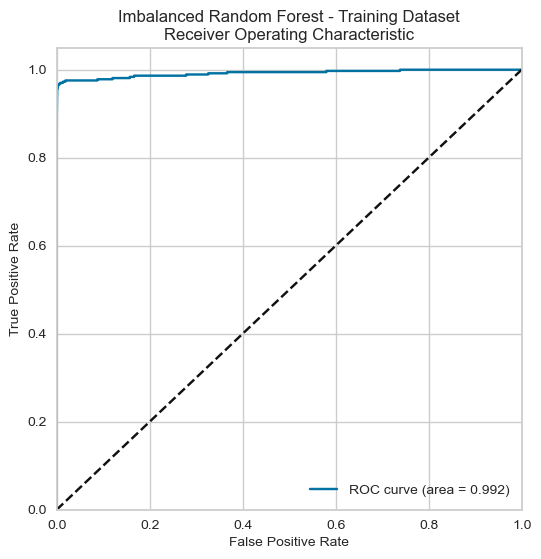

In [26]:
# Plot the ROC curve on the training dataset
plot_roc_curve(y_train, rf_imbalanced_pred_prob_train, 'Imbalanced Random Forest - Training Dataset\nReceiver Operating Characteristic')

### 3.4.3. Random forest model evaluation on test dataset

In [27]:
# Compute the ROC AUC score on the training dataset
rf_imbalanced_pred_prob_test = imbalanced_best_rf.predict_proba(X_test)
roc_auc_score(y_test, rf_imbalanced_pred_prob_test[:, 1])

0.9798993836812973

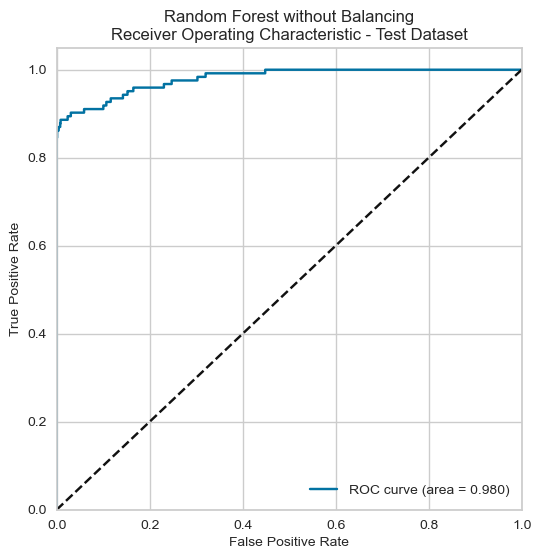

In [28]:
# Plot the ROC curve
plot_roc_curve(y_test, rf_imbalanced_pred_prob_test, 'Random Forest without Balancing\nReceiver Operating Characteristic - Test Dataset')

## 3.5. Feature importance
### 3.5.1. Find the most important predictor variables
This will not give much explanation on the already transformed dataset, but it will help us in understanding if the dataset is not PCA transformed.

In [58]:
# Find the mose important predictor variables
clf = imbalanced_best_rf
var_imp = []
for i in imbalanced_best_rf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(imbalanced_best_rf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(imbalanced_best_rf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(imbalanced_best_rf.feature_importances_)[-3])+1)

Top var = 14
2nd Top var = 17
3rd Top var = 10


### 3.5.2. Visualize the most important predictor variables 

In [59]:
#  Split the training datasets by class
X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

# Shuffle the majority class
np.random.shuffle(X_train_0)

# Get the top 2 predictor variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

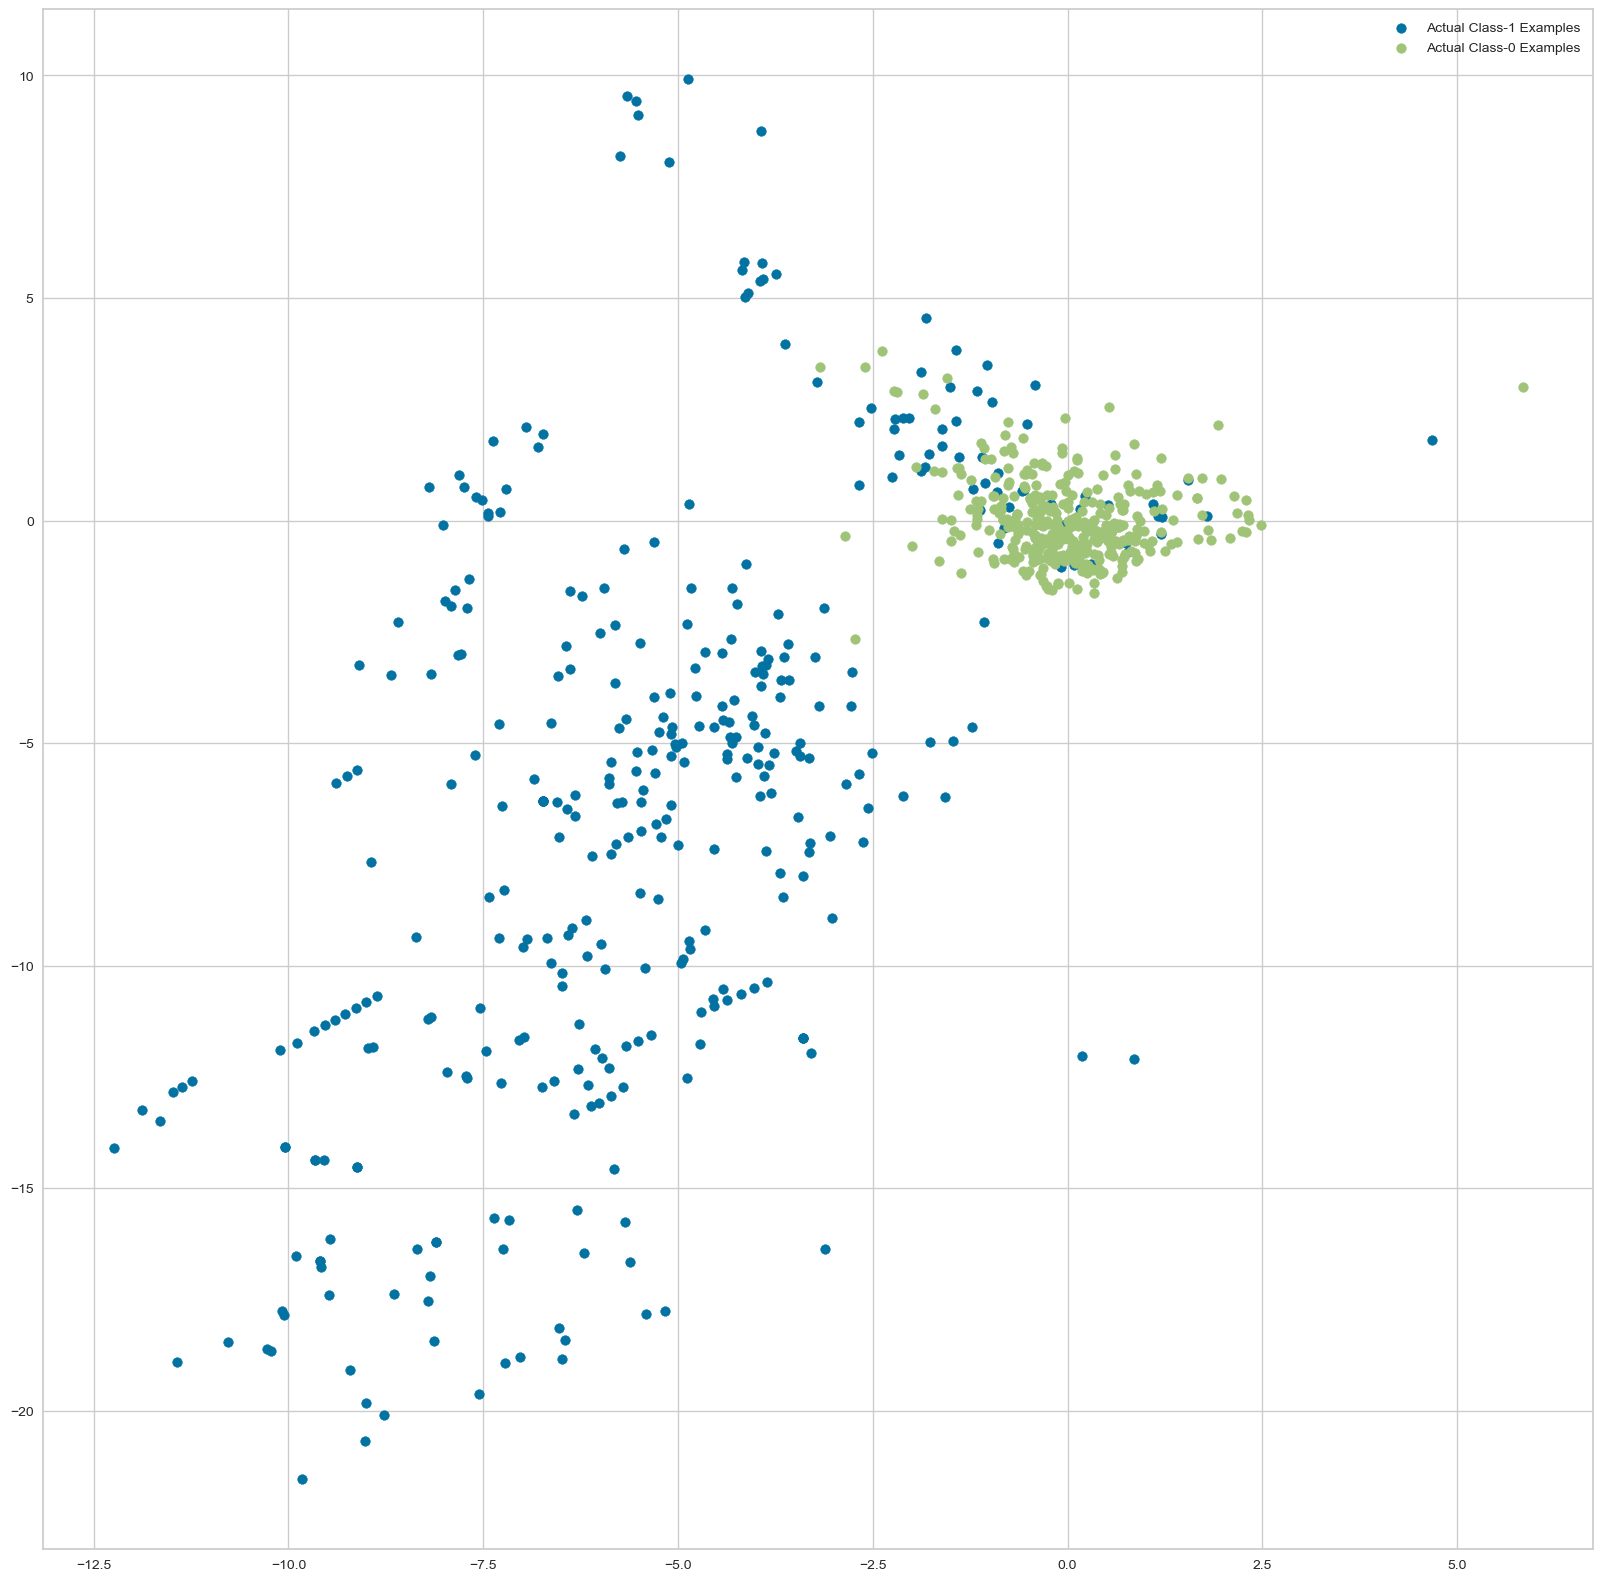

In [60]:
# Plot the distribution of the top 2 predictor variables
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')

plt.legend()
plt.show()

# 4. Model building with random oversampling
Build different models on the balanced dataset and see the result.

## 4.1. Balancing the training data

### 4.1.1 Training data augmentation with random oversampling

In [27]:
# Oversample the training data with a random oversampler
random_oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = random_oversampler.fit_resample(X_train, y_train)

In [28]:
# Validate that the classes are now balanced
y_train_oversampled.value_counts()

0    213236
1    213236
Name: Class, dtype: int64

## 4.2. Compare models with randomly oversampled data

### 4.2.1 Building and comparing models

In [29]:
# Configure an experiment for the balanced dataset with random oversampling
oversampled_experiment = ClassificationExperiment()
oversampled_experiment.setup(data=X_train_oversampled, target=y_train_oversampled, fold_strategy='kfold', fold=5, fold_shuffle=True, preprocess=False, pca=False, normalize=False, transformation=False, fix_imbalance=False, remove_outliers=False, session_id=42, use_gpu=True, html=False, verbose=True)

                   Description         Value
0                   Session id            42
1                       Target         Class
2                  Target type        Binary
3          Original data shape  (426472, 30)
4       Transformed data shape  (426472, 30)
5  Transformed train set shape  (298530, 30)
6   Transformed test set shape  (127942, 30)
7             Numeric features            29


In [30]:
# Build a variety of models using cross validation
oversampled_best = oversampled_experiment.compare_models(cross_validation=True, sort='F1')

                                    Model  Accuracy     AUC  Recall   Prec.  \
rf               Random Forest Classifier    0.9999  1.0000  1.0000  0.9999   
et                 Extra Trees Classifier    0.9999  1.0000  1.0000  0.9999   
lightgbm  Light Gradient Boosting Machine    0.9998  1.0000  1.0000  0.9997   
dt               Decision Tree Classifier    0.9997  0.9997  1.0000  0.9995   
knn                K Neighbors Classifier    0.9995  0.9998  1.0000  0.9989   
gbc          Gradient Boosting Classifier    0.9954  0.9996  0.9972  0.9937   
ada                  Ada Boost Classifier    0.9760  0.9984  0.9679  0.9839   
svm                   SVM - Linear Kernel    0.9516  0.0000  0.9314  0.9706   
lr                    Logistic Regression    0.9515  0.9889  0.9288  0.9731   
ridge                    Ridge Classifier    0.9349  0.0000  0.8862  0.9819   
lda          Linear Discriminant Analysis    0.9349  0.9804  0.8862  0.9819   
qda       Quadratic Discriminant Analysis    0.9340 

* Random forests work well with oversampled data, and it's also the best model in this comparison.
* A simple descision tree also works remarkably well.
* While KNN worked well with imbalanced data, it should not be used with oversampled data.
* With oversampled data, there is always the risk of overfitting.

## 4.3. Finetune Random Forest model on randomly oversampled data

### 4.3.1. Random forest hyperparameter tuning

In [31]:
# Perform automated hyperparameter tuning on the random forest model
oversampled_best_rf = oversampled_experiment.tune_model(RandomForestClassifier(), optimize='AUC', n_iter=4)
print(oversampled_best_rf)

Processing:  14%|█▍        | 1/7 [00:00<00:00,  6.90it/s]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9399  0.9855  0.8906  0.9885  0.9370  0.8798  0.8842
1       0.9405  0.9838  0.8892  0.9907  0.9372  0.8811  0.8857
2       0.9434  0.9864  0.8954  0.9907  0.9407  0.8868  0.8909
3       0.9398  0.9846  0.8899  0.9891  0.9369  0.8797  0.8842
4       0.9434  0.9855  0.8947  0.9902  0.9400  0.8867  0.8908
Mean    0.9414  0.9852  0.8920  0.9899  0.9384  0.8828  0.8872
Std     0.0016  0.0009  0.0026  0.0009  0.0016  0.0033  0.0031
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
 

### 4.3.2. Random forest model evaluation on training dataset

In [41]:
# Compute the ROC AUC score on the training dataset
rf_oversampled_pred_proba_train = oversampled_best_rf.predict_proba(X_train)
roc_auc_score(y_train, rf_oversampled_pred_proba_train[:, 1])

1.0

### 4.3.3. Random forest model evaluation on test dataset

In [42]:
# Compute the ROC AUC score on the test dataset
rf_oversampled_pred_proba_test = oversampled_best_rf.predict_proba(X_test)
roc_auc_score(y_test, rf_oversampled_pred_proba_test[:, 1])

0.9490061270426572

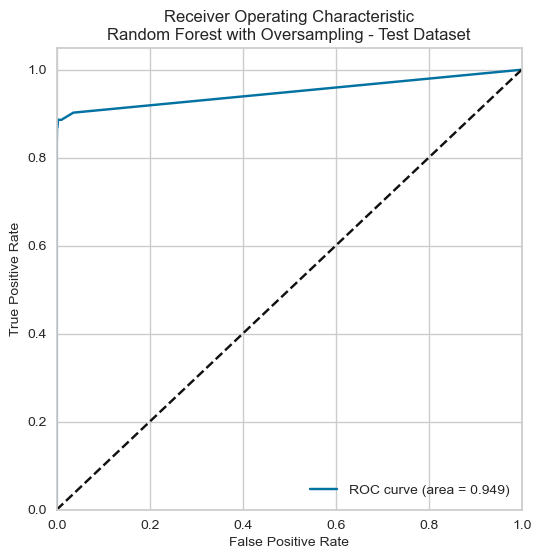

In [43]:
# Plot the ROC curve
plot_roc_curve(y_test, rf_oversampled_pred_proba_test, 'Receiver Operating Characteristic\nRandom Forest with Oversampling - Test Dataset')

## 4.4. Finetune Decision Tree model on randomly oversampled data
Given how close the performance of the decision tree is to the random forest, it is worth investigating futher since decision trees have lower computational requirements.

### 4.4.1. Decision tree hyperparameter tuning

In [38]:
# Perform automated hyperparameter tuning on the random forest model
oversampled_best_dt = oversampled_experiment.tune_model(DecisionTreeClassifier(), optimize='AUC', n_iter=20)
print(oversampled_best_dt)

Processing:  14%|█▍        | 1/7 [00:00<00:00,  6.94it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9981  0.9993     1.0  0.9963  0.9982  0.9963  0.9963
1       0.9981  0.9994     1.0  0.9963  0.9981  0.9963  0.9963
2       0.9985  0.9995     1.0  0.9969  0.9985  0.9969  0.9969
3       0.9983  0.9995     1.0  0.9967  0.9983  0.9967  0.9967
4       0.9981  0.9992     1.0  0.9962  0.9981  0.9962  0.9962
Mean    0.9982  0.9994     1.0  0.9965  0.9982  0.9965  0.9965
Std     0.0001  0.0001     0.0  0.0003  0.0001  0.0003  0.0003
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fract

### 4.4.2. Decision tree model evaluation on training dataset

In [44]:
# Compute the ROC AUC score on the training dataset
dt_oversampled_pred_proba_train = oversampled_best_dt.predict_proba(X_train)
roc_auc_score(y_train, dt_oversampled_pred_proba_train[:, 1])

0.9999437243242228

### 4.3.3. Decision tree model evaluation on test dataset

In [47]:
# Compute the ROC AUC score on the test dataset
dt_oversampled_pred_proba_test = oversampled_best_dt.predict_proba(X_test)
roc_auc_score(y_test, dt_oversampled_pred_proba_test[:, 1])

0.8615353785327834

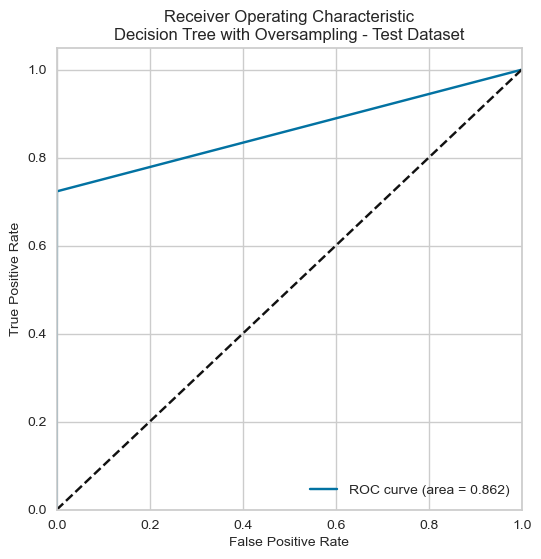

In [48]:
# Plot the ROC curve
plot_roc_curve(y_test, dt_oversampled_pred_proba_test, 'Receiver Operating Characteristic\nDecision Tree with Oversampling - Test Dataset')

* The decision tree model's performance falls short of the random forest.

# 5. Model building with SMOTE augmentation
Augment the training data with synthetic data generated using SMOTE for class balancing.

## 5.1. Balance the training data

### 5.1.1. Training data augmentation with SMOTE

In [27]:
# Apply SMOTE augmentation on the training dataset
smote = SMOTE(k_neighbors=3, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### 5.1.2. Visualizing the synthentic data

In [28]:
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:].to_numpy()

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

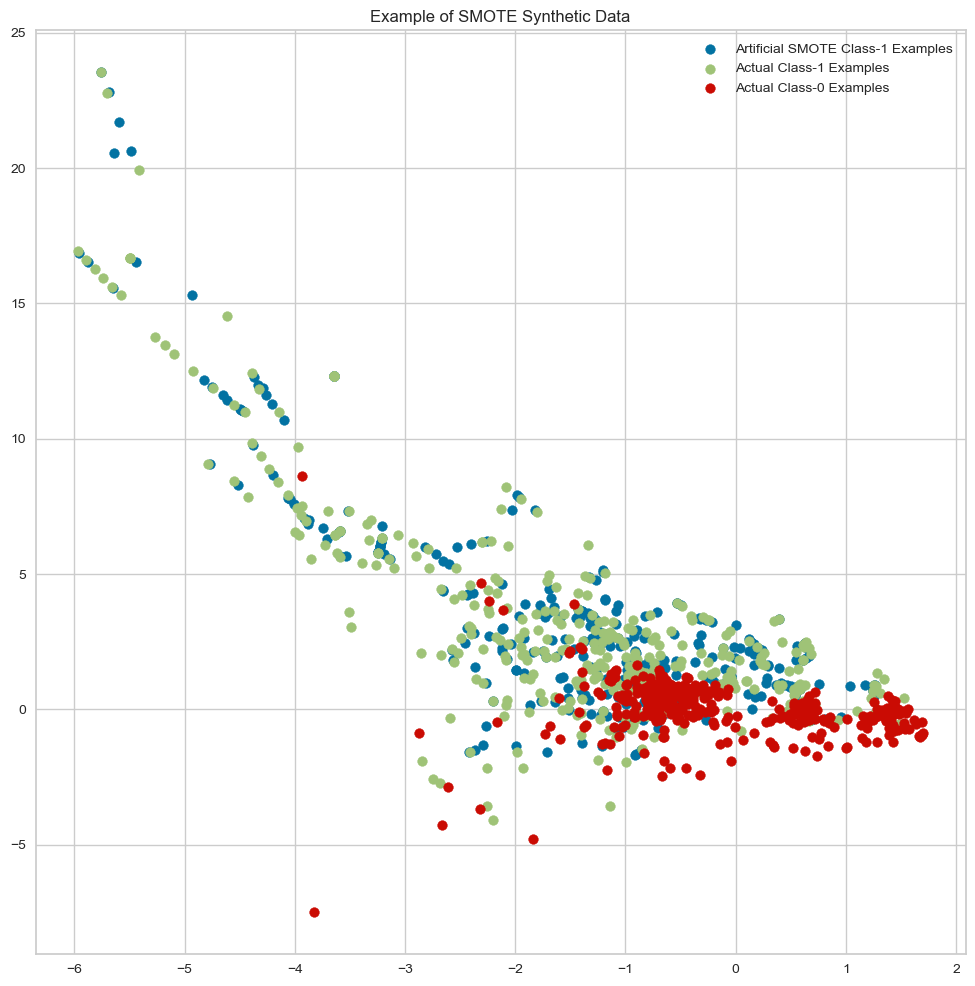

In [29]:
# Plot examples of the synthetic data against the real data
plt.figure(figsize=(12,12))
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1], label='Artificial SMOTE Class-1 Examples')
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()
plt.title('Example of SMOTE Synthetic Data')
plt.show()

## 6.2. Compare models with SMOTE data augmentation

### 6.2.1 Building and comparing models

In [30]:
# Configure an experiment for the balanced dataset with random oversampling
smote_experiment = ClassificationExperiment()
smote_experiment.setup(data=X_train_smote, target=y_train_smote, fold_strategy='kfold', fold=5, fold_shuffle=True, preprocess=False, pca=False, normalize=False, transformation=False, fix_imbalance=False, remove_outliers=False, session_id=42, use_gpu=True, html=False, verbose=True)

                   Description         Value
0                   Session id            42
1                       Target         Class
2                  Target type        Binary
3          Original data shape  (426472, 30)
4       Transformed data shape  (426472, 30)
5  Transformed train set shape  (298530, 30)
6   Transformed test set shape  (127942, 30)
7             Numeric features            29


In [31]:
# Build a variety of models using cross validation
smote_best = smote_experiment.compare_models(cross_validation=True, sort='F1')


Processing: 100%|██████████| 65/65 [52:33<00:00, 11.89s/it]
                                                           

                                    Model  Accuracy     AUC  Recall   Prec.  \
rf               Random Forest Classifier    0.9999  1.0000  1.0000  0.9997   
et                 Extra Trees Classifier    0.9999  1.0000  1.0000  0.9998   
lightgbm  Light Gradient Boosting Machine    0.9994  0.9999  1.0000  0.9988   
knn                K Neighbors Classifier    0.9988  0.9996  1.0000  0.9977   
dt               Decision Tree Classifier    0.9982  0.9982  0.9992  0.9972   
gbc          Gradient Boosting Classifier    0.9835  0.9989  0.9787  0.9881   
ada                  Ada Boost Classifier    0.9679  0.9967  0.9566  0.9787   
svm                   SVM - Linear Kernel    0.9580  0.0000  0.9491  0.9662   
lr                    Logistic Regression    0.9560  0.9916  0.9388  0.9722   
qda       Quadratic Discriminant Analysis    0.9357  0.9867  0.8894  0.9801   
ridge                    Ridge Classifier    0.9326  0.0000  0.8821  0.9812   
lda          Linear Discriminant Analysis    0.9326 

In [37]:
print(smote_best)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)


## 5.2. Finetune Random Forest model with SMOTE augmentation

### 5.2.1. Random forest hyperparameter tuning
Tune the hyperparameters of the Random Forest model with the training data that was balanced with SMOTE. The search used cross validation.  Since the classes are balanced, we can use the F1 score for finding the best model.

In [114]:
# Define the grid of hyperparameters
params = {'n_estimators':[50,100,200], 'min_samples_leaf':[1, 3, 5, 8], 'max_depth':[20, 30, None]}

# Configure a randomized hyperparameter search with cross validation
rf_smote_search = RandomizedSearchCV(smote_best, param_distributions=params, scoring='f1', n_iter=20, random_state=42, cv=5, verbose=3, n_jobs=6)

# Run the search
rf_smote_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='sqrt',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=100, n_jobs=-1,
                                                    oob_score=False,
                                                    random_state=42, verbose=0,
                                                    warm_start=False),
                   n_iter=20, n_jobs=6,
                   param_distributions={'max_depth': [20, 30, None],
                                        'min_samples_leaf': [1, 3, 5, 8],
                                        'n_estimators': [50, 100, 200]},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='f1', verbose=3)

In [118]:
# Display the hyperparameter tuning results
pd.DataFrame(rf_smote_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,552.902293,3.676881,2.699310,0.487330,200,8,None,"{'n_estimators': 200, 'min_samples_leaf': 8, '...",0.999789,0.999801,0.999754,0.999812,0.999836,0.999798,0.000027,16
1,283.879169,10.826095,6.728003,0.759741,100,1,30,"{'n_estimators': 100, 'min_samples_leaf': 1, '...",0.999859,0.999871,0.999836,0.999941,0.999953,0.999892,0.000047,2
2,547.064996,14.942182,6.793811,0.860737,200,1,None,"{'n_estimators': 200, 'min_samples_leaf': 1, '...",0.999859,0.999894,0.999836,0.999941,0.999941,0.999894,0.000043,1
3,159.264277,6.949948,6.188879,1.039357,50,5,None,"{'n_estimators': 50, 'min_samples_leaf': 5, 'm...",0.999836,0.999848,0.999789,0.999859,0.999883,0.999843,0.000031,10
4,273.795038,8.329367,6.414390,1.032881,100,3,30,"{'n_estimators': 100, 'min_samples_leaf': 3, '...",0.999859,0.999871,0.999812,0.999871,0.999918,0.999866,0.000034,6
5,265.539275,8.568812,5.916624,0.885899,100,5,None,"{'n_estimators': 100, 'min_samples_leaf': 5, '...",0.999859,0.999859,0.999777,0.999859,0.999883,0.999848,0.000036,8
6,146.954682,9.790437,4.733524,1.324915,50,8,30,"{'n_estimators': 50, 'min_samples_leaf': 8, 'm...",0.999801,0.999777,0.999742,0.999789,0.999812,0.999784,0.000024,18
7,138.500797,4.307947,5.918064,1.289054,50,1,30,"{'n_estimators': 50, 'min_samples_leaf': 1, 'm...",0.999859,0.999859,0.999836,0.999930,0.999941,0.999885,0.000042,3
8,544.021525,6.463274,6.590117,0.888879,200,5,20,"{'n_estimators': 200, 'min_samples_leaf': 5, '...",0.999812,0.999777,0.999742,0.999824,0.999812,0.999794,0.000030,17
9,536.424093,11.404996,7.063039,1.228753,200,3,30,"{'n_estimators': 200, 'min_samples_leaf': 3, '...",0.999859,0.999883,0.999812,0.999906,0.999894,0.999871,0.000033,4


In [117]:
# Display the hyperparamaters of the best model
rf_smote_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [115]:
# Perform automated hyperparameter tuning on the random forest model
smote_best_rf = smote_experiment.tune_model(RandomForestClassifier(), optimize='AUC', n_iter=10)

Processing:  14%|█▍        | 1/7 [00:00<00:01,  5.52it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9905  0.9998  0.9833  0.9978  0.9905  0.9810  0.9811
1       0.9906  0.9998  0.9835  0.9977  0.9905  0.9812  0.9813
2       0.9889  0.9997  0.9800  0.9979  0.9888  0.9778  0.9780
3       0.9886  0.9997  0.9798  0.9974  0.9885  0.9772  0.9773
4       0.9896  0.9997  0.9817  0.9973  0.9894  0.9792  0.9793
Mean    0.9896  0.9997  0.9816  0.9976  0.9896  0.9793  0.9794
Std     0.0008  0.0000  0.0016  0.0002  0.0008  0.0017  0.0016


### 5.3.2. Random forest model evaluation on training dataset

In [119]:
# Compute the ROC AUC score on the training dataset
rf_smote_pred_proba_train = rf_smote_search.predict_proba(X_train)
roc_auc_score(y_train, rf_smote_pred_proba_train[:, 1])

1.0

### 5.3.3. Random forest model evaluation on training dataset

In [120]:
# Compute the ROC AUC score on the test dataset
rf_smote_pred_proba_test = rf_smote_search.predict_proba(X_test)
roc_auc_score(y_test, rf_smote_pred_proba_test[:, 1])

0.9768324309250774

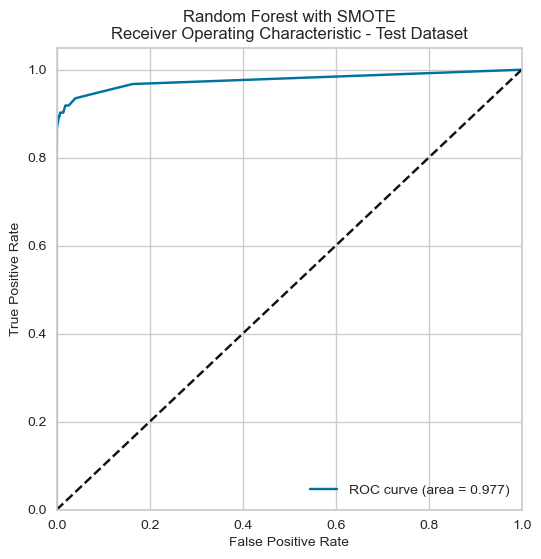

In [121]:
# Plot the ROC AUC curve
plot_roc_curve(y_test, rf_smote_pred_proba_test, 'Random Forest with SMOTE\nReceiver Operating Characteristic - Test Dataset')

* The random forest model with SMOTE augmentation achieves good performance.

## 5.3. Finetune LightGBM model with SMOTE augmentation

### 5.3.1. LightGBM model hyperparameter tuning

In [32]:
# Perform automated hyperparameter tuning on the random forest model
smote_best_lgbm = smote_experiment.tune_model(LGBMClassifier(), optimize='AUC', n_iter=10)


Processing:  14%|█▍        | 1/7 [00:00<00:00,  7.46it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3



Processing: 100%|██████████| 7/7 [02:00<00:00, 11.71s/it]
                                                         

      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.9997  1.0  1.0000  0.9994  0.9997  0.9994  0.9994
1       0.9998  1.0  1.0000  0.9996  0.9998  0.9996  0.9996
2       0.9998  1.0  0.9999  0.9997  0.9998  0.9997  0.9997
3       0.9997  1.0  1.0000  0.9994  0.9997  0.9994  0.9994
4       0.9996  1.0  1.0000  0.9992  0.9996  0.9992  0.9992
Mean    0.9997  1.0  1.0000  0.9995  0.9997  0.9994  0.9994
Std     0.0001  0.0  0.0000  0.0002  0.0001  0.0002  0.0002


In [33]:
print(smote_best_lgbm)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.2, max_depth=-1,
               min_child_samples=81, min_child_weight=0.001, min_split_gain=0.1,
               n_estimators=90, n_jobs=-1, num_leaves=40, objective=None,
               random_state=None, reg_alpha=0.0005, reg_lambda=0.7,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


### 5.3.2. LightGBM model evaluation on training dataset

In [34]:
# Compute the ROC AUC score on the training dataset
lgbm_smote_pred_proba_train = smote_best_lgbm.predict_proba(X_train)
roc_auc_score(y_train, lgbm_smote_pred_proba_train[:, 1])

0.9999939759100456


### 5.3.3. LightGBM model evaluation on test dataset

In [35]:
# Compute the ROC AUC score on the test dataset
lgbm_smote_pred_proba_test = smote_best_lgbm.predict_proba(X_test)
roc_auc_score(y_test, lgbm_smote_pred_proba_test[:, 1])

0.9764593775596305


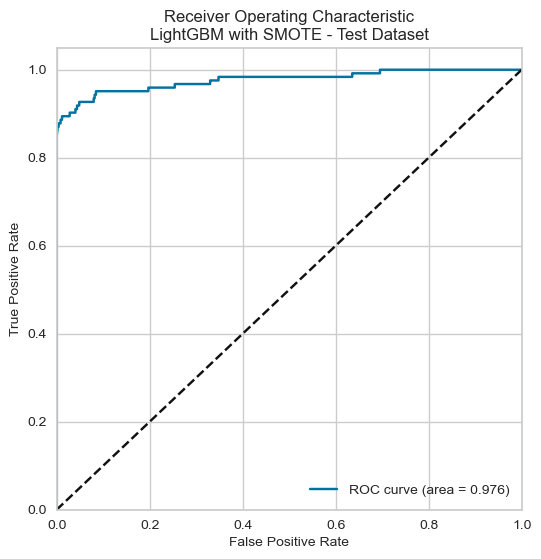

In [36]:
# Plot the ROC AUC curve
plot_roc_curve(y_test, lgbm_smote_pred_proba_test, 'Receiver Operating Characteristic\nLightGBM with SMOTE - Test Dataset')

# 6. Model building with ADASYN augmentation
Build different models on the dataset augmented with ADASYN and see the results.

## 6.1. Balancing the training data

### 6.1.1 Training data augmentation with ADASYN

In [47]:
# Apply SMOTE augmentation on the training dataset
adasyn = ADASYN(n_neighbors=3, random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

### 6.1.2. Visualizing the ADASYN synthentic data

In [48]:
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:].to_numpy()

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

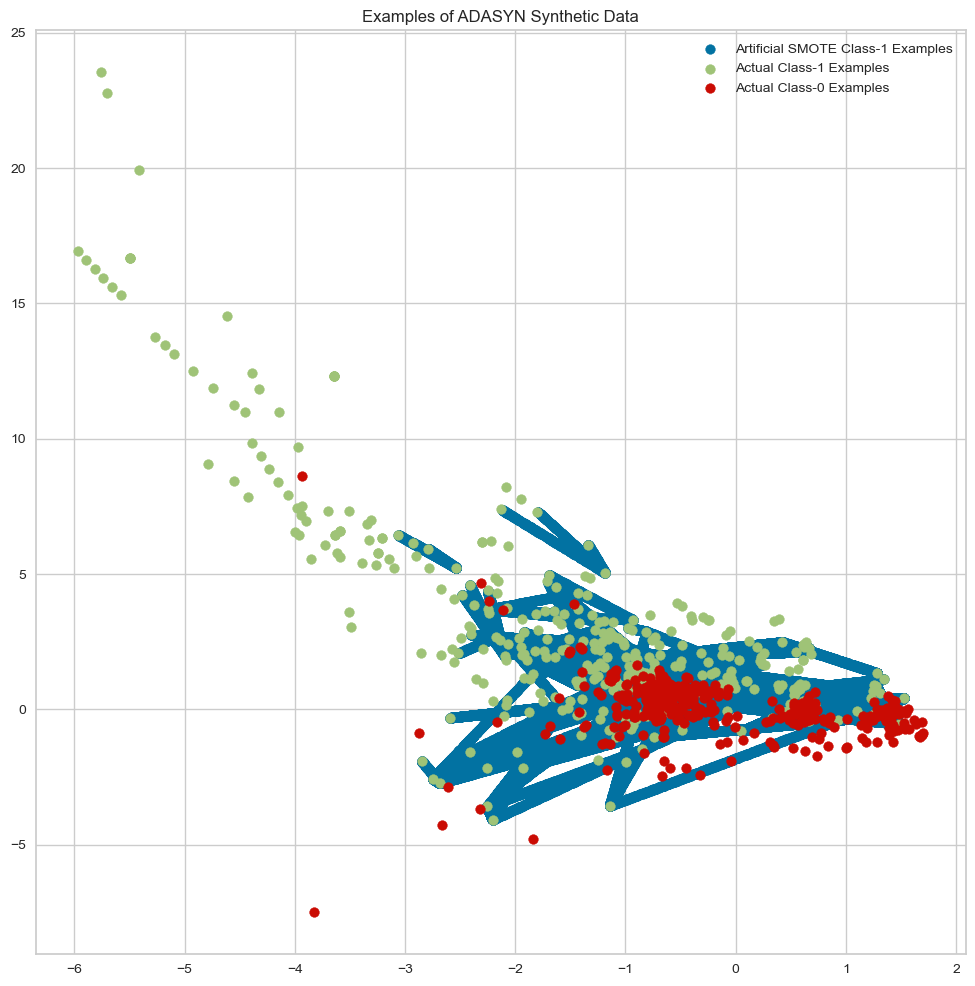

In [49]:
# Plot examples of the synthetic data against the real data
plt.figure(figsize=(12,12))
plt.scatter(X_train_adasyn_1[:, 0], X_train_adasyn_1[:, 1], label='Artificial SMOTE Class-1 Examples')
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()
plt.title('Examples of ADASYN Synthetic Data')
plt.show()

## 6.2. Compare models with ADASYN data augmentation

### 6.2.1 Building and comparing models

In [50]:
# Configure an experiment for the balanced dataset with ADASYN synthetic data
adasyn_experiment = ClassificationExperiment()
adasyn_experiment.setup(data=X_train_adasyn, target=y_train_adasyn, fold_strategy='kfold', fold=5, fold_shuffle=True, preprocess=False, pca=False, normalize=False, transformation=False, fix_imbalance=False, remove_outliers=False, session_id=42, use_gpu=True, html=False, verbose=True)

                   Description         Value
0                   Session id            42
1                       Target         Class
2                  Target type        Binary
3          Original data shape  (426467, 30)
4       Transformed data shape  (426467, 30)
5  Transformed train set shape  (298526, 30)
6   Transformed test set shape  (127941, 30)
7             Numeric features            29


In [51]:
# Build a variety of models using cross validation
adasyn_best = adasyn_experiment.compare_models(exclude = ['gbc'], cross_validation=True, sort='F1')


Processing:   8%|▊         | 5/61 [00:08<01:57,  2.10s/it]
                                                          
Processing: 100%|██████████| 61/61 [18:35<00:00, 13.87s/it]
                                                           

                                    Model  Accuracy     AUC  Recall   Prec.  \
rf               Random Forest Classifier    0.9999  1.0000  1.0000  0.9997   
et                 Extra Trees Classifier    0.9999  1.0000  1.0000  0.9998   
lightgbm  Light Gradient Boosting Machine    0.9991  0.9999  1.0000  0.9982   
knn                K Neighbors Classifier    0.9988  0.9996  1.0000  0.9976   
dt               Decision Tree Classifier    0.9985  0.9985  0.9993  0.9976   
ada                  Ada Boost Classifier    0.9467  0.9880  0.9497  0.9441   
qda       Quadratic Discriminant Analysis    0.9373  0.9754  0.9155  0.9572   
svm                   SVM - Linear Kernel    0.9110  0.0000  0.9075  0.9138   
lr                    Logistic Regression    0.9005  0.9663  0.8899  0.9091   
ridge                    Ridge Classifier    0.8718  0.0000  0.8460  0.8920   
lda          Linear Discriminant Analysis    0.8718  0.9474  0.8460  0.8920   
nb                            Naive Bayes    0.7445 

* The random forest, extra trees, light GBM, and k nearest neighbors models perform well on the training data.
* Given the similar performance between models, light GBM has an advantage in speed.

## 6.3. Finetune LightGBM model with ADASYN augmentation

### 6.3.1. LightGBM model hyperparameter tuning

In [52]:
# Perform automated hyperparameter tuning on the random forest model
adasyn_best_lgbm = adasyn_experiment.tune_model(LGBMClassifier(), optimize='AUC', n_iter=10)

Processing:  14%|█▍        | 1/7 [00:00<00:00,  7.14it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.9995  1.0     1.0  0.9991  0.9995  0.9991  0.9991
1       0.9997  1.0     1.0  0.9994  0.9997  0.9994  0.9994
2       0.9997  1.0     1.0  0.9994  0.9997  0.9994  0.9994
3       0.9997  1.0     1.0  0.9993  0.9997  0.9993  0.9993
4       0.9996  1.0     1.0  0.9991  0.9996  0.9991  0.9991
Mean    0.9996  1.0     1.0  0.9993  0.9996  0.9993  0.9993
Std     0.0001  0.0     0.0  0.0001  0.0001  0.0001  0.0001


In [53]:
print(adasyn_best_lgbm)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.2, max_depth=-1,
               min_child_samples=81, min_child_weight=0.001, min_split_gain=0.1,
               n_estimators=90, n_jobs=-1, num_leaves=40, objective=None,
               random_state=None, reg_alpha=0.0005, reg_lambda=0.7,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


### 6.3.2. LightGBM model evaluation on training dataset

In [54]:
# Compute the ROC AUC score on the training dataset
lgbm_adasyn_pred_proba_train = adasyn_best_lgbm.predict_proba(X_train)
print(roc_auc_score(y_train, lgbm_adasyn_pred_proba_train[:, 1]))

0.9999918789167069


### 6.3.3. LightGBM model evaluation on test dataset

In [55]:
# Compute the ROC AUC score on the test dataset
lgbm_adasyn_pred_proba_test = adasyn_best_lgbm.predict_proba(X_test)
print(roc_auc_score(y_test, lgbm_adasyn_pred_proba_test[:, 1]))

0.9773046525467998


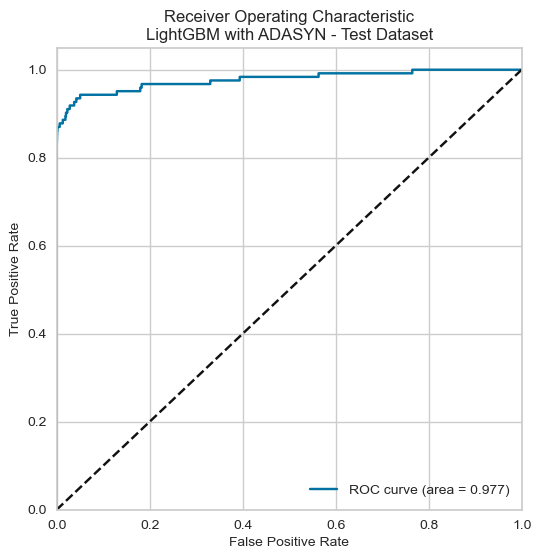

In [56]:
# Plot the ROC AUC curve
plot_roc_curve(y_test, lgbm_adasyn_pred_proba_test, 'Receiver Operating Characteristic\nLightGBM with ADASYN - Test Dataset')

* LightGBM with ADASYN appears to be promising combination.

# 7. Final model

### 7.1. Compare the best models 

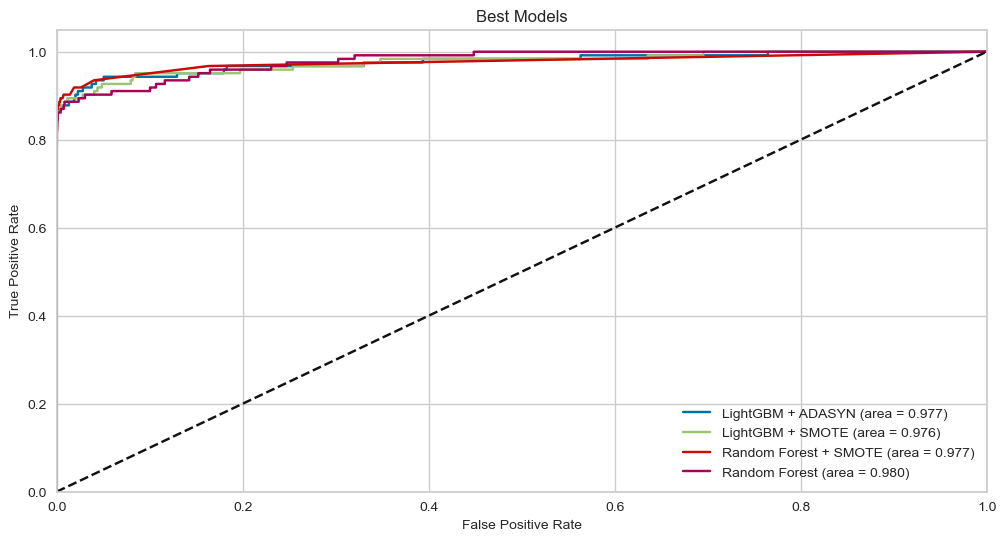

In [232]:
# Create a figure
plt.figure(figsize=(12, 6))

# Plot the curve for LightGBM with ADASYN
fpr, tpr, thresholds = metrics.roc_curve(y_test, lgbm_adasyn_pred_proba_test[:,1], drop_intermediate = False )
auc_score = metrics.roc_auc_score(y_test, lgbm_adasyn_pred_proba_test[:,1] )
plt.plot( fpr, tpr, label='LightGBM + ADASYN (area = %0.3f)' % auc_score )

# Plot the curve for LightGBM with SMOTE
fpr, tpr, thresholds = metrics.roc_curve(y_test, lgbm_smote_pred_proba_test[:,1], drop_intermediate = False )
auc_score = metrics.roc_auc_score(y_test, lgbm_smote_pred_proba_test[:,1] )
plt.plot( fpr, tpr, label='LightGBM + SMOTE (area = %0.3f)' % auc_score )

# Plot the curve for Random Forest with SMOTE
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_smote_pred_proba_test[:,1], drop_intermediate = False )
auc_score = metrics.roc_auc_score(y_test, rf_smote_pred_proba_test[:,1] )
plt.plot( fpr, tpr, label='Random Forest + SMOTE (area = %0.3f)' % auc_score )

# Plot the curve for Random Forest with imbalanced data
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_imbalanced_pred_prob_test[:,1], drop_intermediate = False )
auc_score = metrics.roc_auc_score(y_test, rf_imbalanced_pred_prob_test[:,1] )
plt.plot( fpr, tpr, label='Random Forest (area = %0.3f)' % auc_score )

# Plot the figure
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('Best Models', fontsize=12)
plt.legend(loc="lower right")
plt.show()

### 7.2. Final model and data augmentation method

In [131]:
# Initialise the model with optimum hyperparameters
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [132]:
# Fit on the balanced dataset
clf.fit(X_train_best, y_train_best)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### 7.3. Feature importance

In [222]:
# Find the most important predictor variables
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

Top var = 4
2nd Top var = 14
3rd Top var = 12


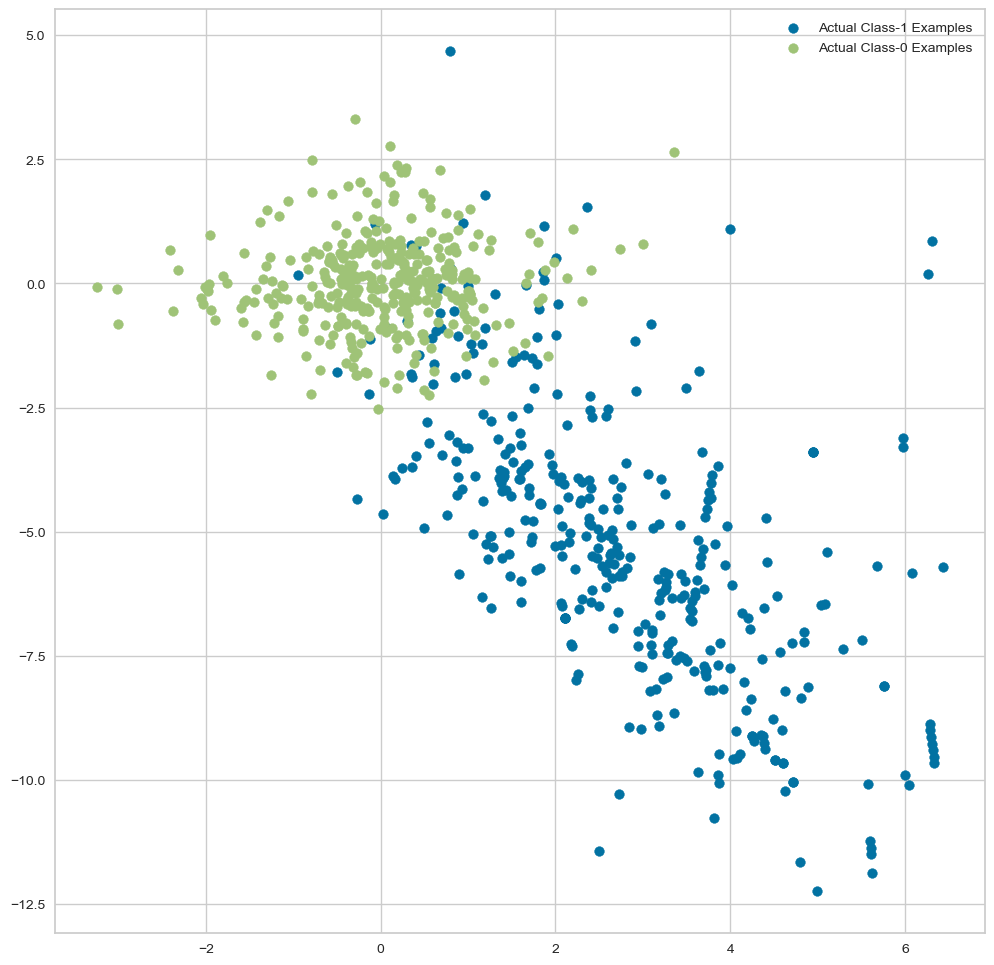

In [223]:
# Plot the distribution of the top 2 predictor variables
plt.figure(figsize=(12,12))
plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()
plt.show()

### 7.4. Model performance metrics

In [133]:
# Compute the ROC AUC score on the test dataset
best_pred_proba_test = clf.predict_proba(X_test)
print('Test dataset AUC: ', roc_auc_score(y_test, best_pred_proba_test[:, 1]))

Test dataset AUC:  0.9655225029015578


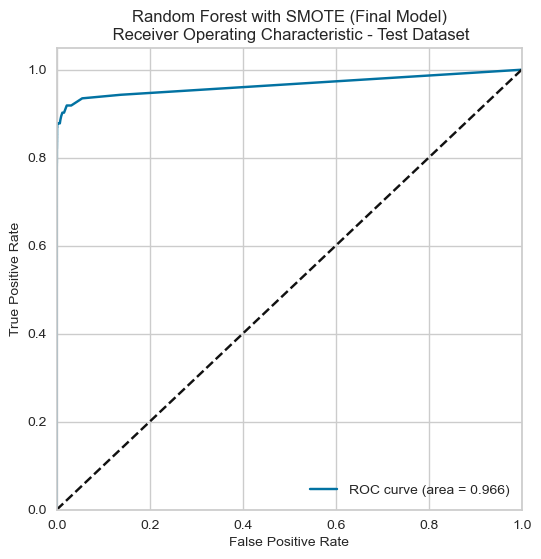

In [204]:
# Plot the ROC AUC curve
plot_roc_curve(y_test, best_pred_proba_test, 'Random Forest with SMOTE (Final Model)\n Receiver Operating Characteristic - Test Dataset')

### 7.5. Tune the descision threshold

In [219]:
# Manually tune the decision threshold
threshold = 0.15

# Apply the optimal threshold
probability_to_prediction = np.vectorize(lambda x: 1 if x >= threshold else 0)
y_pred = probability_to_prediction(best_pred_proba_test[:,1])

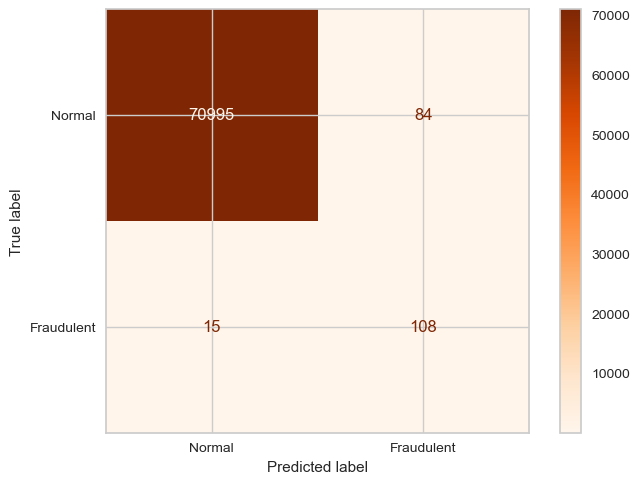

In [220]:
# Compute the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraudulent'])
disp.plot(cmap=plt.cm.Oranges, values_format='')

In [221]:
# Compute accuracy metrics of a model from the confusion matrix
true_positive = cm[1][1]
true_negative = cm[0][0]
false_positive = cm[0][1]
false_negative = cm[1][0]
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = 2 * (precision * recall) / (precision + recall)
false_positive_rate = false_positive / (false_positive + true_negative)
print('f1 score:            ', round(f1_score, 4))
print('Precision:           ', round(precision, 4))
print('Recall:              ', round(recall, 4))
print('False positive rate: ', round(false_positive_rate, 4))

f1 score:             0.6857
Precision:            0.5625
Recall:               0.878
False positive rate:  0.0012


* Model performance is a trade-off between the false positive rate and true positive rate.
* We can significantly reduce the false positive rate with a small sacrifice in the true positive rate.
* The final model detects 87.8% of fraudunlent transactions on the test dataset while only incorrectly flagging 0.12% of normal transactions as fraudulent.